In [1]:
import pandas as pd 
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse 
from sklearn.model_selection import train_test_split

class MF(object):
    def __init__(self, Y, k, X = None, W = None, lamda = 0.1,
                dist_func = cosine_similarity, learning_rate = 0.5, max_iter = 1000, user_based = 1):
        self.f = open('danhgiaMF.dat', 'a+')
        self.Y = Y
        self.lamda = lamda
        self.k = k
        self.dist_func = dist_func
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.user_based = user_based
        self.users_count = int(np.max(self.Y[:, 0])) + 1
        self.items_count = int(np.max(self.Y[:, 1])) + 1
        self.ratings_count = Y.shape[0]
        if X == None:
            self.X = np.random.randn(self.items_count, k)
        if W == None:
            self.W = np.random.randn(k, self.users_count)
        self.Ybar = self.Y.copy()
        
    def normalizeY(self):
        if self.user_based:
            user_col = 0
            item_col = 1
            n_objects = self.users_count
        else:
            user_col = 1
            item_col = 0 
            n_objects = self.items_count
        users = self.Y[:, user_col]
        self.mu = np.zeros((n_objects,))
        for i in range(n_objects):
            ids = np.where(users == i)[0].astype(int)
            ratings = self.Y[ids, 2]
            m = np.mean(ratings)
            if np.isnan(m):
                m = 0
            self.mu[i] = m
            self.Ybar[ids, 2] = ratings - self.mu[i]
#         print(self.Ybar)
    
    def get_user_rated_item(self, i):
        ids = np.where(i == self.Ybar[:, 1])[0].astype(int)
        users = self.Ybar[ids, 0].astype(int)
        ratings = self.Ybar[ids, 2]
        
        return (users, ratings)
        

    def get_item_rated_by_user(self, u):
        ids = np.where(u == self.Ybar[:, 0])[0].astype(int)
        items = self.Ybar[ids, 1].astype(int)
        ratings = self.Ybar[ids, 2]
        
        return (items, ratings)
    
    def updateX(self):
        for i in range(self.items_count):
            users, ratings = self.get_user_rated_item(i)
            Wi = self.W[:, users]
            a = -(ratings - self.X[i, :].dot(Wi)).dot(Wi.T)/self.ratings_count + \
            self.lamda*self.X[i, :]
            self.X[i, :] -= self.learning_rate*(a).reshape((self.k,))
        
    def updateW(self):
        for u in range(self.users_count):
            items, ratings = self.get_item_rated_by_user(u)
            Xn = self.X[items, :]
            a = -Xn.T.dot(ratings - Xn.dot(self.W[:, u]))/self.ratings_count + self.lamda*self.W[:, u]
            self.W[:, u] -= self.learning_rate*(a).reshape((self.k,))
        
    def fit(self):
        self.normalizeY()
        for it in range(self.max_iter):
            self.updateX()
            self.updateW()
            
    def pred(self, u, i):
        u = int(u)
        i = int(i)
        if self.user_based:
            bias = self.mu[u]
        else: 
            bias = self.mu[i]
        pred = self.X[i, :].dot(self.W[:, u]) + bias
        
        if pred < 1:
            return 1 
        if pred > 5: 
            return 5
        return pred
    
    def RMSE(self, data_size, Data_test, test_size = 0.1):
        n_tests = Data_test.shape[0]
        SE = 0
        for n in range(n_tests):
            if Data_test[n, 1] == 1681:
                pred = 0
            else:
                pred = self.pred(Data_test[n, 0], Data_test[n, 1])
            SE += (pred - Data_test[n, 2])**2 

        RMSE = np.sqrt(SE/n_tests)
        print('RMSE =', RMSE)
        if self.user_based:
            print('%s::1::%d::cosine_similarity::%r::%r\r\n' % (str(data_size), self.k, test_size, RMSE))
            self.f.write('%s::1::%d::cosine_similarity::%r::%r\r\n' % (str(data_size), self.k, test_size, RMSE))
        else:
            print('%s::0::%d::cosine_similarity::%r::%r\r\n' % (str(data_size), self.k, test_size, RMSE))
            self.f.write('%s::0::%d::cosine_similarity::%r::%r\r\n' % (str(data_size), self.k, test_size, RMSE))
        self.f.close()

In [5]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestemp']
ratings = pd.read_csv('mvl/1M.dat', sep = '::', names = r_cols, encoding='latin-1')
Y_data = ratings.as_matrix()
for testSize in np.arange(0.2, 0.6, 0.1):
    Data_train, Data_test= train_test_split(Y_data, test_size=testSize, random_state=20)
    for j in [0, 1]:
        rs = MF(Data_train, k = 2, lamda = 0.1, learning_rate = 2, max_iter = 10, user_based = j)
        rs.fit()
        rs.RMSE('1M', Data_test, test_size = testSize)

/home/tran.thi.hai.ha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/home/tran.thi.hai.ha/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tran.thi.hai.ha/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


RMSE = 0.981551914764402
1M::0::2::cosine_similarity::0.2::0.981551914764402

RMSE = 1.037606663188771
1M::1::2::cosine_similarity::0.2::1.037606663188771

RMSE = 0.9806335336422325
1M::0::2::cosine_similarity::0.30000000000000004::0.9806335336422325

RMSE = 1.0369936764645347
1M::1::2::cosine_similarity::0.30000000000000004::1.0369936764645347

RMSE = 0.980216476770738
1M::0::2::cosine_similarity::0.4000000000000001::0.980216476770738

RMSE = 1.0362479676878835
1M::1::2::cosine_similarity::0.4000000000000001::1.0362479676878835

RMSE = 0.9817307666356478
1M::0::2::cosine_similarity::0.5000000000000001::0.9817307666356478

RMSE = 1.0378532872672301
1M::1::2::cosine_similarity::0.5000000000000001::1.0378532872672301



In [ ]:
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('mvl/10M.dat', sep = '::', names = r_cols, encoding='latin-1')
Y_data = ratings.as_matrix()

for testSize in np.arange(0.1, 0.5, 0.1):
    Data_train, Data_test= train_test_split(Y_data, test_size=testSize, random_state=20)
    for x in [2, 5, 10]:
        rs = MF(Data_train, k = x, lamda = 0.1, learning_rate = 2, max_iter = 10, user_based = 0)
        rs.fit()
        rs.RMSE('10M', Data_test, test_size = testSize)

/home/tran.thi.hai.ha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/home/tran.thi.hai.ha/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tran.thi.hai.ha/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestemp']

ratings_base_1 = pd.read_csv('mvl/100K.base', sep='\t', names=r_cols, encoding='latin-1', engine='python')

ratings_matrix_1 = ratings_base_1.as_matrix()

ratings_matrix_1[:, :2] -= 1

testSize = 0.1
Data_train_1, Data_test_1= train_test_split(ratings_matrix_1, test_size = testSize, random_state=20)

rs_1 = MF(Data_train_1, k = 100, lamda = 0.01, learning_rate = 2)
rs_1.fit()

rs_1.RMSE("100K", Data_test_1, test_size = testSize)

In [ ]:
r_cols = ['user_id', 'item_id', 'rating']
ratings = pd.read_csv('ex.dat', sep = ' ', names = r_cols, encoding='latin-1')
Y_data = ratings.as_matrix()

rs = MF(Y_data, k = 2)

rs.fit()
rs.pred(6, 1)

   dataset  uMF    k          dist_func  test_size      RMSE
0     100K    0   10  cosine_similarity        0.1  1.048642
1     100K    1   10  cosine_similarity        0.1  1.060380
2     100K    0   10  cosine_similarity        0.1  1.048642
3     100K    1   10  cosine_similarity        0.1  1.060380
4     100K    0   10  cosine_similarity        0.1  1.048642
5     100K    1  100  cosine_similarity        0.1  1.043703
6       1M    0    2  cosine_similarity        0.1  0.981748
7       1M    1    2  cosine_similarity        0.1  1.036504
8       1M    0    5  cosine_similarity        0.1  0.981967
9       1M    1    5  cosine_similarity        0.1  1.036630
10      1M    0   10  cosine_similarity        0.1  0.982461
11      1M    1   10  cosine_similarity        0.1  1.036941
12      1M    0    2  cosine_similarity        0.2  0.981552
13      1M    1    2  cosine_similarity        0.2  1.037607
14      1M    0    2  cosine_similarity        0.3  0.980634
15      1M    1    2  co

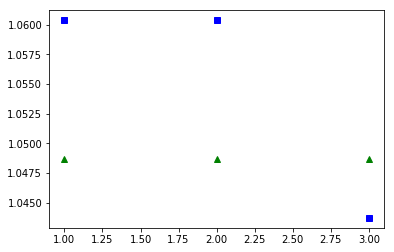

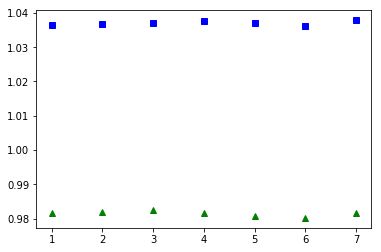

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

r_cols = ['dataset', 'uMF', 'k','dist_func', 'test_size', 'RMSE']

RMSEs = pd.read_csv('danhgiaMF.dat', sep='::', names=r_cols, encoding='latin-1', engine='python')

rs = RMSEs.as_matrix()
print(RMSEs)
dataset = rs[:, 0]
uMF = rs[:, 1]

for n in ['100K', '1M']:
    ids_ii = np.where((dataset == n) & (uMF == 0))[0].astype(np.int32)
    ids_uu = np.where((dataset == n) & (uMF == 1))[0].astype(np.int32)
    items_ii = rs[ids_ii, 5]
    items_uu = rs[ids_uu, 5]
    t_ii = range(1, ids_ii.shape[0] + 1, 1)
    t_uu = range(1, ids_uu.shape[0] + 1, 1)
    plt.plot(t_ii, items_ii, 'g^', t_uu, items_uu, 'bs')
    plt.show()